In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.utils as ku 
import pickle
import logging

from generators import PasswordBatchGenerator
from utils import add_spaces, transform_password, pad_and_tokenize
from data_preparation import construct_subsequences, ff_labels, rnn_labels
from predict_utils import predict_letter, predict_next_letter, predict_password

print(tf.keras.__version__)
tf.test.gpu_device_name()

2.11.0


2023-01-15 17:22:55.561019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 17:22:55.561642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 17:22:55.562051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 17:22:55.562636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 17:22:55.562654: I tensorflow/core/co

'/device:GPU:0'

In [12]:
#!pip install pandas
#!pip install --timeout=10000 matplotlib
#!pip install pydot
#!pip install tensorflow-text
#!pip install joblib

In [13]:
try:
    with open('data.pkl', 'rb') as file:
        df = pickle.load(file)
except:
    # Load the Password list into Memory
    url = "https://raw.githubusercontent.com/danielmiessler/SecLists/master/Passwords/Common-Credentials/10-million-password-list-top-1000000.txt"

    df_in = pd.read_csv(url, header=None)

    df = transform_password(df_in)
    with open('data.pkl', 'wb') as file:
        # Cache Data
        pickle.dump(df, file)

In [14]:
limit = 10_000
sequences = construct_subsequences(df, limit=10_000)

In [15]:
from keras.preprocessing.text import Tokenizer

#We us a Tokenizer to code each Letter into a number

tokenizer  = Tokenizer(filters=None, char_level=True, lower=False)
tokenizer.fit_on_texts(sequences)

# Translation from Word to Token and back
word2idx = tokenizer.word_index
idx2word = tokenizer.index_word
vocab_size = len(word2idx) + 1

In [16]:
# The one hot matrix is nice, but we don't need that
#1. get max password length

max_length = max([len(x) for x in sequences])

In [17]:
tok_sequence = pad_and_tokenize(sequences, tokenizer, max_length)

In [54]:
predictors, label = ff_labels(tok_sequence, vocab_size)

In [61]:
# Init generator
batch_size= 10_000
training_batch = PasswordBatchGenerator(predictors, label, batch_size)

In [62]:
try:
  with open(f'/app/models/ff_model_{str(limit)}.pkl', 'rb') as file:
      ff_model = pickle.load(file)
      logging.info(ff_model.summary())
except:# FileNotFoundError:
  ff_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(vocab_size,), activation="sigmoid"),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
  ])
  ff_model.compile(
                #optimizer='rmsprop',
                loss='categorical_crossentropy',
                optimizer='adam')

  ff_model.fit( training_batch , epochs=100, verbose=1)

  # cache the model
  with open(f'/app/models/ff_model_{str(limit)}.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(ff_model, file)

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-01-15 17:35:44           64
config.json                                    2023-01-15 17:35:44         1380
variables.h5                                   2023-01-15 17:35:44       150024
Epoch 1/100
6/6 [==============================] - 1s 19ms/step - loss: 4.2637
Epoch 2/100
6/6 [==============================] - 0s 17ms/step - loss: 3.9409
Epoch 3/100
6/6 [==============================] - 0s 17ms/step - loss: 3.7092
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 3.5504
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 3.4432
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 3.3655
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 3.3090
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 3.2670
Epoch 9/100
6/6 [====

In [40]:
logging.info(ff_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 68)                1156      
                                                                 
 dense_9 (Dense)             (None, 68)                4692      
                                                                 
Total params: 5,848
Trainable params: 5,848
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Split the Data into trainset and labels

predictors, label = rnn_labels(tok_sequence, vocab_size)

In [22]:
# Init generator
batch_size= 10_000
training_batch = PasswordBatchGenerator(predictors, label, batch_size)

In [23]:
try:
  with open(f'/app/models/rnn_model_{str(limit)}.pkl', 'rb') as file:
      rnn_model = pickle.load(file)
      logging.info(rnn_model.summary())
except FileNotFoundError:
  rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 10, input_length=max_length-1), #Turns positive integers (indexes) into dense vectors of fixed size.
    tf.keras.layers.Masking(mask_value=0),
    tf.keras.layers.SimpleRNN(100), # skips masked timesteps
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
  ])
  rnn_model.compile(
                #optimizer='rmsprop',
                loss='categorical_crossentropy',
                optimizer='adam')

  rnn_model.fit( training_batch , epochs=100, verbose=1)

  # cache the model
  with open(f'/app/models/rnn_model_{str(limit)}.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(rnn_model, file)

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-01-15 17:13:18           64
config.json                                    2023-01-15 17:13:18         2400
variables.h5                                   2023-01-15 17:13:18       250080
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......embedding
.........vars
............0
......masking
.........vars
......simple_rnn
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Model: "sequential_15"
___________________________________________

In [24]:
try:
  with open(f'/app/models/lstm_model_{str(limit)}.pkl', 'rb') as file:
      lstm_model = pickle.load(file)
      logging.info(lstm_model.summary())
except:
  lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 10, input_length=max_length-1), #Turns positive integers (indexes) into dense vectors of fixed size.
    tf.keras.layers.Masking(mask_value=0),
    tf.keras.layers.LSTM(100), # skips masked timesteps
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
  ])
  lstm_model.compile(
                #optimizer='rmsprop',
                loss='categorical_crossentropy',
                optimizer='adam')

  lstm_model.fit( training_batch , epochs=100, verbose=1)

  # cache the model
  with open(f'/app/models/lstm_model_{str(limit)}.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(lstm_model, file)


Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-01-15 17:16:16           64
config.json                                    2023-01-15 17:16:16         2469
variables.h5                                   2023-01-15 17:16:16       649824
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......masking
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Model: "sequential_16"
_________________________________________________

In [25]:

# https://stackoverflow.com/questions/43341374/tensorflow-dynamic-rnn-lstm-how-to-format-input
# https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html
# https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275
# https://ai.stackexchange.com/questions/18198/what-is-the-difference-between-lstm-and-rnn#:~:text=The%20main%20difference%20between%20an%20LSTM%20unit%20and,better%20the%20flow%20of%20information%20through%20the%20unit.


In [26]:
import pickle

# pickle model
with open('/root/model.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(lstm_model, file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......masking
.........vars
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-01-15 17:23:10           64
config.json                                    2023-01-15 17:23:10         2469
variables.h5                                   2023-01-15 17:23:10       226232


1/1 [==============================] - 0s 50ms/step


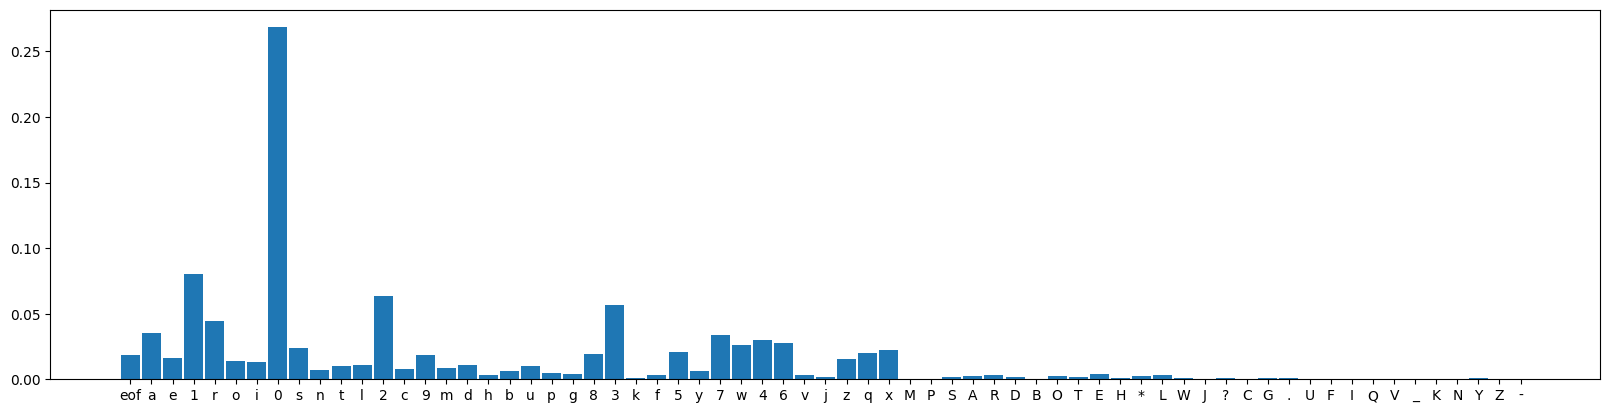

1/1 [==============================] - 0s 28ms/step


'FGDan1ir'

In [30]:
predict_next_letter("LOV", lstm_model, tokenizer, True)
predict_password("FGD", lstm_model, tokenizer )

In [42]:
predict_next_letter("L", ff_model, tokenizer, True)
#predict_password("FGD", ff_model, tokenizer )

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_5' (type Sequential).
    
    Input 0 of layer "dense_10" is incompatible with the layer: expected axis -1 of input shape to have value 16, but received input with shape (None, 1)
    
    Call arguments received by layer 'sequential_5' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=int32)
      • training=False
      • mask=None


In [28]:
#https://jhui.github.io/2017/03/15/RNN-LSTM-GRU/
#https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn
#https://www.kaggle.com/code/namansood/nlp-guide-next-word-prediction-and-deep-learning